<a href="https://colab.research.google.com/github/Tatianakami/spark-sentiment-analysis/blob/main/Sentiment_Analysis_Pipeline_ipyn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Instalação do PySpark**

In [1]:
!pip install pyspark

**Iniciando uma sessão**

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("analise_nlp") \
    .getOrCreate()

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("analise_nlp") \
    .getOrCreate()

Leitura dos **dados**

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("analise_nlp") \
    .getOrCreate()

# Definindo o caminho direto para o arquivo dentro da pasta que encontramos
caminho_imdb = "/content/drive/MyDrive/ModuloSpark2_processamento_de_linguagem_natural/imdb-reviews-pt-br.csv"

# Lendo os dados com as configurações para texto (NLP)
dados = spark.read.csv(caminho_imdb,
                       escape="\\",
                       header=True,
                       inferSchema=True)

# Mostrando o resultado para confirmar
print(f"Sucesso! O dataset tem {dados.count()} avaliações.")
dados.show(5, truncate=50) # truncate=50 ajuda a ler o texto sem cortar muito

Sucesso! O dataset tem 49459 avaliações.
+---+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
| id|                                           text_en|                                           text_pt|                                         sentiment|
+---+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
|  1|Once again Mr. Costner has dragged out a movie ...|Mais uma vez, o Sr. Costner arrumou um filme po...|                                               neg|
|  2|This is an example of why the majority of actio...|Este é um exemplo do motivo pelo qual a maioria...|                                               neg|
|  3|First of all I hate those moronic rappers, who ...|"Primeiro de tudo eu odeio esses raps imbecis, ...| exceto Paxton e o sem-teto e todos recebem o q...|
|  4|

**Explorando os dados(estrutura, tamanho dos dados)**

In [5]:
print(f'Numero de linhas:{dados.count()}', f'numero de colunas:{len(dados.columns)}')

Numero de linhas:49459 numero de colunas:4


 **Campos e Tipos**

In [6]:
dados.printSchema()

root
 |-- id: integer (nullable = true)
 |-- text_en: string (nullable = true)
 |-- text_pt: string (nullable = true)
 |-- sentiment: string (nullable = true)



**Tamanho dos dados**

In [7]:
print(f'Nº linhas:{dados.count()}',f'\nNº colunas:{len(dados.columns)}')

Nº linhas:49459 
Nº colunas:4


In [8]:
# Conteudo
# dados.head() não traz a estrutura desejada

dados.limit(99).show()

+---+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|           sentiment|
+---+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|                 neg|
|  2|This is an exampl...|Este é um exemplo...|                 neg|
|  3|First of all I ha...|"Primeiro de tudo...| exceto Paxton e ...|
|  4|Not even the Beat...|Nem mesmo os Beat...|                 neg|
|  5|Brass pictures mo...|Filmes de fotos d...|                 neg|
|  6|"A funny thing ha...| the hero is a de...|           excuse me|
|  7|This German horro...|Este filme de ter...|                 neg|
|  8|"Being a long-tim...| plots and twists...|         forcedly so|
|  9|"""Tokyo Eyes"" t...|                talk| and more talk. Y...|
| 10|Wealthy horse ran...|Fazendeiros ricos...|                 neg|
| 11|"Cage plays a dru...|"Cage interpreta ...|                 neg|
| 12|First of all, I w...|Primeiro

In [9]:
# Apresentando alguns comentários ditos como negativo ou positivo.

print("Negativo")
dados.filter(dados.id == 190).select('text_pt').show(truncate=False)

print("Positivo")
dados.filter(dados.id == 12427).select('text_pt').show(truncate=False)

Negativo
+---------------------------------------------------------------------------+
|text_pt                                                                    |
+---------------------------------------------------------------------------+
| to a film that tries to spread an Archchristian ""Judgement day is at hand|
+---------------------------------------------------------------------------+

Positivo
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [10]:
# Lendo o arquivo com "paredes reforçadas" (parâmetros extras)
dados = spark.read.csv(caminho_imdb,
                       header=True,
                       inferSchema=True,
                       quote="\"",       # Diz que o texto está protegido por aspas
                       escape="\"",      # Diz para não se assustar com aspas duplas ""
                       multiLine=True)   # Avisa que um comentário pode pular de linha

# AGORA TESTE O NEGATIVO NOVAMENTE:
print("Negativo (ID 190) - Agora deve estar em Português:")
dados.filter(dados.id == 190).select('text_pt').show(truncate=False)

Negativo (ID 190) - Agora deve estar em Português:
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_pt                                                                       

In [11]:
# Contabilizando os tipos de comentários
dados.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



In [12]:
# Proporção dos comentários
# conseguimos perceber que nossos dados são balanceados.
import pyspark.sql.functions as f
from pyspark.sql.window import Window

conta_classe=dados.groupBy('sentiment').count()
conta_classe.withColumn("(%)", f.round(f.col('count')/f.sum('count').over(Window.partitionBy())*100, 2)).show()

+---------+-----+-----+
|sentiment|count|  (%)|
+---------+-----+-----+
|      pos|24694|49.93|
|      neg|24765|50.07|
+---------+-----+-----+



In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [14]:
dados.limit(10).show()

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
+---+--------------------+--------------------+---------+



**WordCloud**

In [15]:
amostra = dados.select('text_pt').sample(fraction = 0.1, seed = 101)

In [16]:
# 3. Transformar em uma lista que o Python entenda (Atenção aos colchetes!)
tudo = [texto['text_pt'] for texto in amostra.collect()]

In [17]:
# 4. Criar a Nuvem de Palavras

wordcloud = WordCloud(background_color='white',
                      width=1000,
                      height=600,
                      collocations=False,
                      prefer_horizontal=1.0).generate(str(tudo))

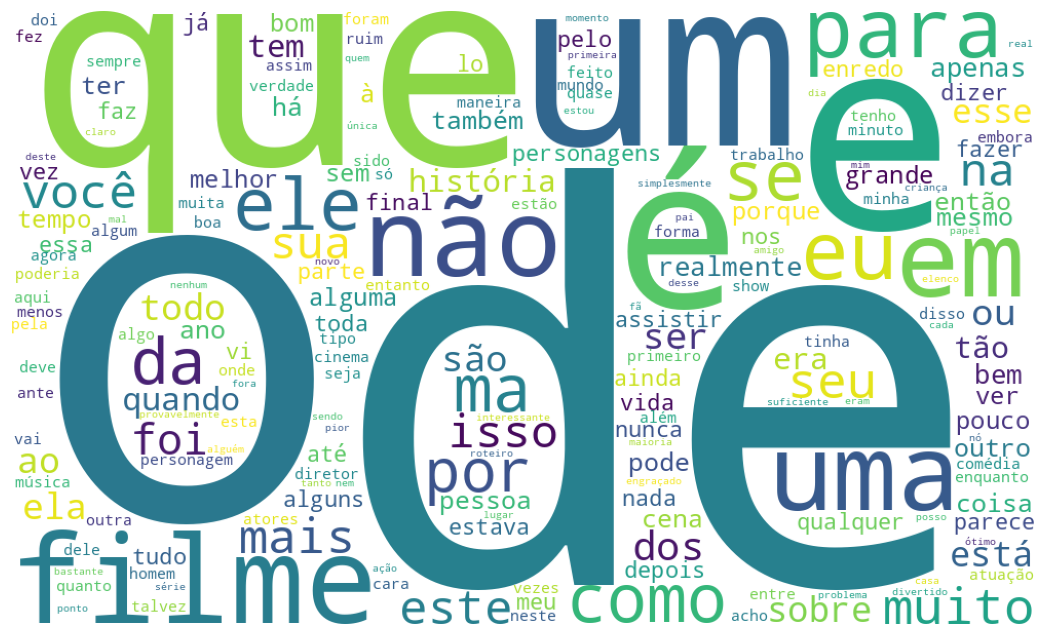

In [18]:
# 5. Mostrar na tela
plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.axis("off") # Esconde os números dos eixos para ficar limpo
plt.show()

**Limpeza:caracteres especiais**

In [19]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [20]:
amostra = spark.createDataFrame([
                ("Oi, JP! Blz?",),
                ("$$$\\ |~ Parabéns ~| \\$$$",),
                ("(#amovc #paz&amor ^.^)",),
                ("\"bora *_* \"",),
                ("=>->'...``` vc foi selecionad@ ´´´...'<=<-",),
                ("{comprar: arroz; feijão e pepino} //",),
                ("!\"#$&'()*+,-./:;<=>?@[\]^_`{|}~",),
                ("ana@gmail.com",)
        ], ["textos"])

<>:8: SyntaxWarning: invalid escape sequence '\]'
<>:8: SyntaxWarning: invalid escape sequence '\]'
/tmp/ipython-input-4155172965.py:8: SyntaxWarning: invalid escape sequence '\]'
  ("!\"#$&'()*+,-./:;<=>?@[\]^_`{|}~",),


In [21]:
import pyspark.sql.functions as f

In [22]:
amostra = amostra.withColumn("texto_regex", f.regexp_replace("textos", "\$", ""))

<>:1: SyntaxWarning: invalid escape sequence '\$'
<>:1: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipython-input-1322999324.py:1: SyntaxWarning: invalid escape sequence '\$'
  amostra = amostra.withColumn("texto_regex", f.regexp_replace("textos", "\$", ""))


In [23]:
amostra = amostra.withColumn("texto_regex", f.regexp_replace("textos", "[\$#,\"!%&'()*+-./;:<=>?@^_`´{|}~\\\\]", ""))
amostra.show(truncate = False)

<>:1: SyntaxWarning: invalid escape sequence '\$'
<>:1: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipython-input-3842689827.py:1: SyntaxWarning: invalid escape sequence '\$'
  amostra = amostra.withColumn("texto_regex", f.regexp_replace("textos", "[\$#,\"!%&'()*+-./;:<=>?@^_`´{|}~\\\\]", ""))


+------------------------------------------+------------------------------+
|textos                                    |texto_regex                   |
+------------------------------------------+------------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                     |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                    |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                 |
|"bora *_* "                               |bora                          |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad            |
|{comprar: arroz; feijão e pepino} //      |comprar arroz feijão e pepino |
|!"#$&'()*+,-./:;<=>?@[\]^_`{|}~           |[]                            |
|ana@gmail.com                             |anagmailcom                   |
+------------------------------------------+------------------------------+



In [24]:
amostra = amostra.withColumn("texto_limpo", f.trim(amostra.texto_regex))
amostra.show(truncate = False)

+------------------------------------------+------------------------------+-----------------------------+
|textos                                    |texto_regex                   |texto_limpo                  |
+------------------------------------------+------------------------------+-----------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                     |Oi JP Blz                    |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                    |Parabéns                     |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                 |amovc pazamor                |
|"bora *_* "                               |bora                          |bora                         |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad            |vc foi selecionad            |
|{comprar: arroz; feijão e pepino} //      |comprar arroz feijão e pepino |comprar arroz feijão e pepino|
|!"#$&'()*+,-./:;<=>?@[\]^_`{|}~           |[]

In [25]:
dados = dados.withColumn("texto_regex", f.regexp_replace("text_en", "[\$#,\"!%&'()*+-./;;<=>?@^_`´{|}~\\\\]", ""))

dados.limit(2).show(truncate = False)

<>:1: SyntaxWarning: invalid escape sequence '\$'
<>:1: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipython-input-2610588675.py:1: SyntaxWarning: invalid escape sequence '\$'
  dados = dados.withColumn("texto_regex", f.regexp_replace("text_en", "[\$#,\"!%&'()*+-./;;<=>?@^_`´{|}~\\\\]", ""))


+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [26]:
dados = dados.withColumn("texto_limpo", f.trim(dados.texto_regex))

In [27]:
dados.limit(2).show(truncate=False, vertical=True)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [28]:
# Criando uma lista de palavras que "entregam" que o texto é inglês
stopwords_ingles = [" the ", " and ", " is ", " of ", " to ", " with "]

# Filtrando para manter APENAS o que NÃO tem essas palavras
dados_portugues = dados
for palavra in stopwords_ingles:
    # O sinal ~ significa "NÃO"
    dados_portugues = dados_portugues.filter(~f.col("text_pt").contains(palavra))

print(f"Agora você tem {dados_portugues.count()} linhas apenas em português!")

Agora você tem 44753 linhas apenas em português!


In [29]:
# Comparando o antes e o depois
print(f"Total de linhas antes: {dados.count()}")
print(f"Total de linhas só em Português: {dados_portugues.count()}")

# Ver o resultado
dados_portugues.select("text_pt").show(5, truncate=100)

Total de linhas antes: 49459
Total de linhas só em Português: 44753
+----------------------------------------------------------------------------------------------------+
|                                                                                             text_pt|
+----------------------------------------------------------------------------------------------------+
|Mais uma vez, o Sr. Costner arrumou um filme por muito mais tempo do que o necessário. Além das t...|
|Este é um exemplo do motivo pelo qual a maioria dos filmes de ação são os mesmos. Genérico e chat...|
|Primeiro de tudo eu odeio esses raps imbecis, que não poderiam agir se tivessem uma arma pression...|
|Nem mesmo os Beatles puderam escrever músicas que todos gostassem, e embora Walter Hill não seja ...|
|Filmes de fotos de latão não é uma palavra apropriada para eles, na verdade, são um tanto ousados...|
+----------------------------------------------------------------------------------------------------+
only 

**O Fatiador de Palavras (Tokenização)**

In [30]:
from pyspark.ml.feature import Tokenizer
from pyspark.sql.types import IntegerType
import pyspark.sql.functions as f

# 1. Preparando a máquina de fatiar.
# Ela pega o 'texto_limpo' e joga o resultado na coluna 'tokens'.
tokenizer = Tokenizer(inputCol="texto_limpo", outputCol="tokens")

# 2. Passo os meus dados pela máquina.
# O legal é que o Tokenizer já deixa tudo MINÚSCULO sozinho! Menos um trabalho pra mim.
tokenizado = tokenizer.transform(dados)

# 3. Vou criar uma regrinha rápida para contar quantas palavras tem em cada frase.
# É um contador de palavras automático.
countTokens = f.udf(lambda lista: len(lista), IntegerType())

# 4. Agora eu mostro o texto, a lista de palavras e o total de palavras (frequência).
tokenizado.select("texto_limpo", "tokens") \
    .withColumn("Freq_tokens", countTokens(f.col("tokens"))).show()

+--------------------+--------------------+-----------+
|         texto_limpo|              tokens|Freq_tokens|
+--------------------+--------------------+-----------+
|Once again Mr Cos...|[once, again, mr,...|        168|
|This is an exampl...|[this, is, an, ex...|        232|
|First of all I ha...|[first, of, all, ...|        215|
|Not even the Beat...|[not, even, the, ...|        308|
|Brass pictures mo...|[brass, pictures,...|        238|
|A funny thing hap...|[a, funny, thing,...|        115|
|This German horro...|[this, german, ho...|        156|
|Being a longtime ...|[being, a, longti...|        136|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|        129|
|Wealthy horse ran...|[wealthy, horse, ...|        160|
|Cage plays a drun...|[cage, plays, a, ...|        109|
|First of all I wo...|[first, of, all, ...|        333|
|So tell me  what ...|[so, tell, me, , ...|        243|
|A big disappointm...|[a, big, disappoi...|        110|
|This film is abso...|[this, film, is, ...|     

**StopWords**

In [31]:
from pyspark.ml.feature import StopWordsRemover
import nltk
from nltk.corpus import stopwords

In [32]:
# 1. Baixando a "lista de lixo" oficial do português (NLTK)
nltk.download("stopwords")
stop_portugues = stopwords.words("portuguese")

# 2. Configurando a máquina de limpeza
# Ela pega meus 'tokens' e cria a coluna 'texto_final' sem a sujeira.
remover = StopWordsRemover(inputCol="tokens",
                           outputCol="texto_final",
                           stopWords=stop_portugues)

# 3. Rodando a limpeza nos meus dados tokenizados
feature_data = remover.transform(tokenizado)

# 4.  Vamos ver quanto "peso" a gente perdeu?
print("Comparando a dieta dos tokens:")
feature_data.select("tokens", "texto_final") \
    .withColumn("Antes", countTokens(f.col("tokens"))) \
    .withColumn("Depois", countTokens(f.col("texto_final"))) \
    .show(5)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Comparando a dieta dos tokens:
+--------------------+--------------------+-----+------+
|              tokens|         texto_final|Antes|Depois|
+--------------------+--------------------+-----+------+
|[once, again, mr,...|[once, again, mr,...|  168|   159|
|[this, is, an, ex...|[this, is, an, ex...|  232|   225|
|[first, of, all, ...|[first, of, all, ...|  215|   203|
|[not, even, the, ...|[not, even, the, ...|  308|   295|
|[brass, pictures,...|[brass, pictures,...|  238|   230|
+--------------------+--------------------+-----+------+
only showing top 5 rows


**Bag of words**

In [33]:
from pyspark.ml.feature import CountVectorizer

In [34]:
# 1. Preparando a  "Sacola".
# Ela olha para o 'texto_final' (que já tá limpo) e cria a coluna 'CountVec'.
cv = CountVectorizer(inputCol="texto_final", outputCol="CountVec")

# 2. O 'fit' é o Spark aprendendo quais palavras existem no mundo.
# Ele cria um dicionário (modelo) com todas as palavras únicas.
modelo_sacola = cv.fit(feature_data)

# 3. O 'transform' é onde ele realmente carimba os números nos nossos dados.
dados_vetorizados = modelo_sacola.transform(feature_data)

# 4. as palavras que ele aprendeu?
# Isso aqui é o nosso "Dicionário do Spark".
print("As primeiras palavras do nosso dicionário:")
print(modelo_sacola.vocabulary[:10])

# 5. Mostrando o resultado final (Palavras vs Números)
dados_vetorizados.select('texto_final', 'CountVec').limit(5).show(truncate=False)

As primeiras palavras do nosso dicionário:
['the', 'and', 'of', 'to', 'is', 'in', 'it', 'i', 'this', 'that']
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Hashing TF**

In [36]:
from pyspark.ml.feature import HashingTF

# 1. Preparando o "Funil" de palavras.
# Eu digo de onde vem (texto_final) e onde coloco o resultado (hashingTF).
htf = HashingTF(inputCol="texto_final", outputCol="hashingTF")

# 2. Aqui eu defino o limite.
# "Spark, eu só quero 50 gavetas para guardar tudo isso, ok?"
htf.setNumFeatures(50)

# 3. Rodando a transformação.
# Repare que aqui NÃO usamos o .fit(), vamos direto para o .transform().
# Isso acontece porque o Hashing é uma conta matemática, ele não precisa "aprender" as palavras antes.
dados_hashing = htf.transform(feature_data)

# 4. Vendo o resultado compacto
dados_hashing.select("texto_final", "hashingTF").limit(5).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [38]:
from pyspark.ml.feature import IDF

# 1. Preparando o "Juiz" (IDF).
# Ele olha para os números do HashingTF e decide quem ganha mais peso.
# O resultado vai para a coluna 'features' (esse é o nome padrão que a IA gosta).
idf = IDF(inputCol="hashingTF", outputCol="features")

# 2. O 'fit' aqui é obrigatório!
# O Spark precisa ler a base toda para saber quais palavras são "comuns" e quais são "raras".
modelo_idf = idf.fit(dados_hashing)

# 3. Agora ele carimba os pesos nos nossos dados.
dados_finalizados = modelo_idf.transform(dados_hashing)

# 4. Vendo o resultado (Agora os números não são mais inteiros, são decimais/pesos!)
dados_finalizados.select('texto_final', 'features').limit(5).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Pipeline**

In [40]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF

# 1. PEÇA 1: O fatiador de palavras
tokenizer = Tokenizer(inputCol="texto_limpo", outputCol="tokens")

# 2. PEÇA 2: O filtro de palavras inúteis
stopwords = StopWordsRemover(inputCol="tokens", outputCol="texto_final")

# 3. PEÇA 3: O contador rápido (limitando a 1000 palavras para ser potente)
hashingTF = HashingTF(inputCol="texto_final", outputCol="HTF", numFeatures=1000)

# 4. PEÇA 4: O juiz que dá peso ao que importa (TF-IDF)
tfidf = IDF(inputCol="HTF", outputCol="features")

# 🚀 A ESTEIRA (Pipeline): Coloco as peças na ordem certa
pipeline_da_tati = Pipeline(stages=[tokenizer, stopwords, hashingTF, tfidf])

# 5. Ligo a fábrica!
# O .fit() aprende com os dados e o .transform() entrega o resultado pronto.
dados_finalizados = pipeline_da_tati.fit(dados).transform(dados)

# 6. Conferindo o final da linha de produção
dados_finalizados.select("sentiment", "features").show(5)

+---------+--------------------+
|sentiment|            features|
+---------+--------------------+
|      neg|(1000,[10,21,34,4...|
|      neg|(1000,[0,3,11,12,...|
|      neg|(1000,[1,7,33,38,...|
|      neg|(1000,[0,3,10,12,...|
|      neg|(1000,[3,6,7,11,3...|
+---------+--------------------+
only showing top 5 rows


In [42]:
from pyspark.ml import Pipeline


In [47]:
# 1. Separando os dados (70% pra estudar, 30% pra testar)
# A 'seed' garante que o sorteio seja sempre igual toda vez que eu rodar.
treino, teste = dados.randomSplit([0.7, 0.3], seed=101)

# 2. O MOMENTO DO ESTUDO (.fit)
# Aqui o Pipeline vai rodar tudo: limpar, tokenizar, pesar e a Árvore vai criar as regras.
# O resultado é o 'modelo_pronto'.
modelo_pronto = pipeline.fit(treino)

# 3. O MOMENTO DA PROVA (.transform)
# Agora eu peço para o modelo tentar adivinhar o sentimento dos dados de TESTE.
previsoes = modelo_pronto.transform(teste)

# 4. Vendo o resultado (O que era real vs O que a IA achou)
previsoes.select("label", "prediction").show(10)

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
+-----+----------+
only showing top 10 rows


In [50]:

# 2.  Árvore de Decisão,
# garantindo que ela use o 'label' que já está lá:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=10)

# 3. o pipeline e para o fit:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[tokenizer, stopwords, hashingTF, tfidf, dt])

# 4. Agora sim, treine o modelo:
modelo_pronto = pipeline.fit(treino)

**Teste e métricas**

In [54]:

predictions = modelo_pronto.transform(teste)

# 2. Agora o avaliador vai encontrar a variável!
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

prof_avaliador = MulticlassClassificationEvaluator(labelCol='label',
                                                   predictionCol='prediction',
                                                   metricName='accuracy')

# mesmo nome
nota_final = prof_avaliador.evaluate(predictions)

print(f"Acurácia: {nota_final:.2f}")

Acurácia: 0.67


In [56]:
# 1. Crio as frases que eu quero que a IA classifique.
# IMPORTANTE: A coluna tem que ter o mesmo nome (texto_limpo) que o Pipeline espera!
frases_novas = spark.createDataFrame([
        (1, "This is without doubt the worst movie i have ever seen, I hated the acting of the actor."), # Ruim
        (0, "I loved the movie, excellent acting!"), # Bom
    ], ["id", "texto_limpo"])

# 2. Uso o meu modelo treinado para "adivinhar"
# Ele vai fazer a faxina, tokenizar, pesar e dar o veredito sozinho.
resultado_final = modelo_pronto.transform(frases_novas)

# 3. Mostro o resultado na tela
resultado_final.select("texto_limpo", "prediction").show(truncate=False)

+----------------------------------------------------------------------------------------+----------+
|texto_limpo                                                                             |prediction|
+----------------------------------------------------------------------------------------+----------+
|This is without doubt the worst movie i have ever seen, I hated the acting of the actor.|0.0       |
|I loved the movie, excellent acting!                                                    |1.0       |
+----------------------------------------------------------------------------------------+----------+



In [58]:
#  salvar seu modelo e usar depois sem precisar treinar de novo
modelo_pronto.save("modelo_sentimentos_imdb_v1")

# Calcule o F1-Score (criterio)
evaluator_f1 = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
f1 = evaluator_f1.evaluate(predictions)
print(f"F1-Score do Modelo: {f1:.2f}")

F1-Score do Modelo: 0.67
